# Research Question #2: Bayesian Regression and MCMC

## Imports

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load dataset

In [51]:
data = pd.read_csv('cleaned_and_complete_data_without_outliers.csv')
data.shape

(13048, 32)

In [52]:
pd.DataFrame(data)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Building_and_land_price_per_m2,is_Eastern_Victoria,is_Northern_Metropolitan,is_Northern_Victoria,is_South_Eastern_Metropolitan,is_Southern_Metropolitan,is_Western_Metropolitan,is_Western_Victoria,YearSold,HouseAge
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,2016-12-03,2.5,3067.0,...,4150.308469,False,True,False,False,False,False,False,2016,120
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-02-04,2.5,3067.0,...,4404.255319,False,True,False,False,False,False,False,2016,116
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-03-04,2.5,3067.0,...,5158.450704,False,True,False,False,False,False,False,2017,117
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,2017-03-04,2.5,3067.0,...,4020.813623,False,True,False,False,False,False,False,2017,55
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-06-04,2.5,3067.0,...,6106.870229,False,True,False,False,False,False,False,2016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13043,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,2017-08-26,16.7,3150.0,...,1426.116838,False,False,False,True,False,False,False,2017,36
13044,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,2017-08-26,6.8,3016.0,...,2212.446352,False,False,False,False,False,True,False,2017,22
13045,Williamstown,83 Power St,3,h,1170000.0,S,Raine,2017-08-26,6.8,3016.0,...,1795.580110,False,False,False,False,False,True,False,2017,20
13046,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,2017-08-26,6.8,3016.0,...,2443.792766,False,False,False,False,False,True,False,2017,97


In [53]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13048 entries, 0 to 13047
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Suburb                          13048 non-null  object 
 1   Address                         13048 non-null  object 
 2   Rooms                           13048 non-null  int64  
 3   Type                            13048 non-null  object 
 4   Price                           13048 non-null  float64
 5   Method                          13048 non-null  object 
 6   SellerG                         13048 non-null  object 
 7   Date                            13048 non-null  object 
 8   Distance                        13048 non-null  float64
 9   Postcode                        13048 non-null  float64
 10  Bedroom2                        13048 non-null  float64
 11  Bathroom                        13048 non-null  float64
 12  Car                             

## Missing Values

<Axes: >

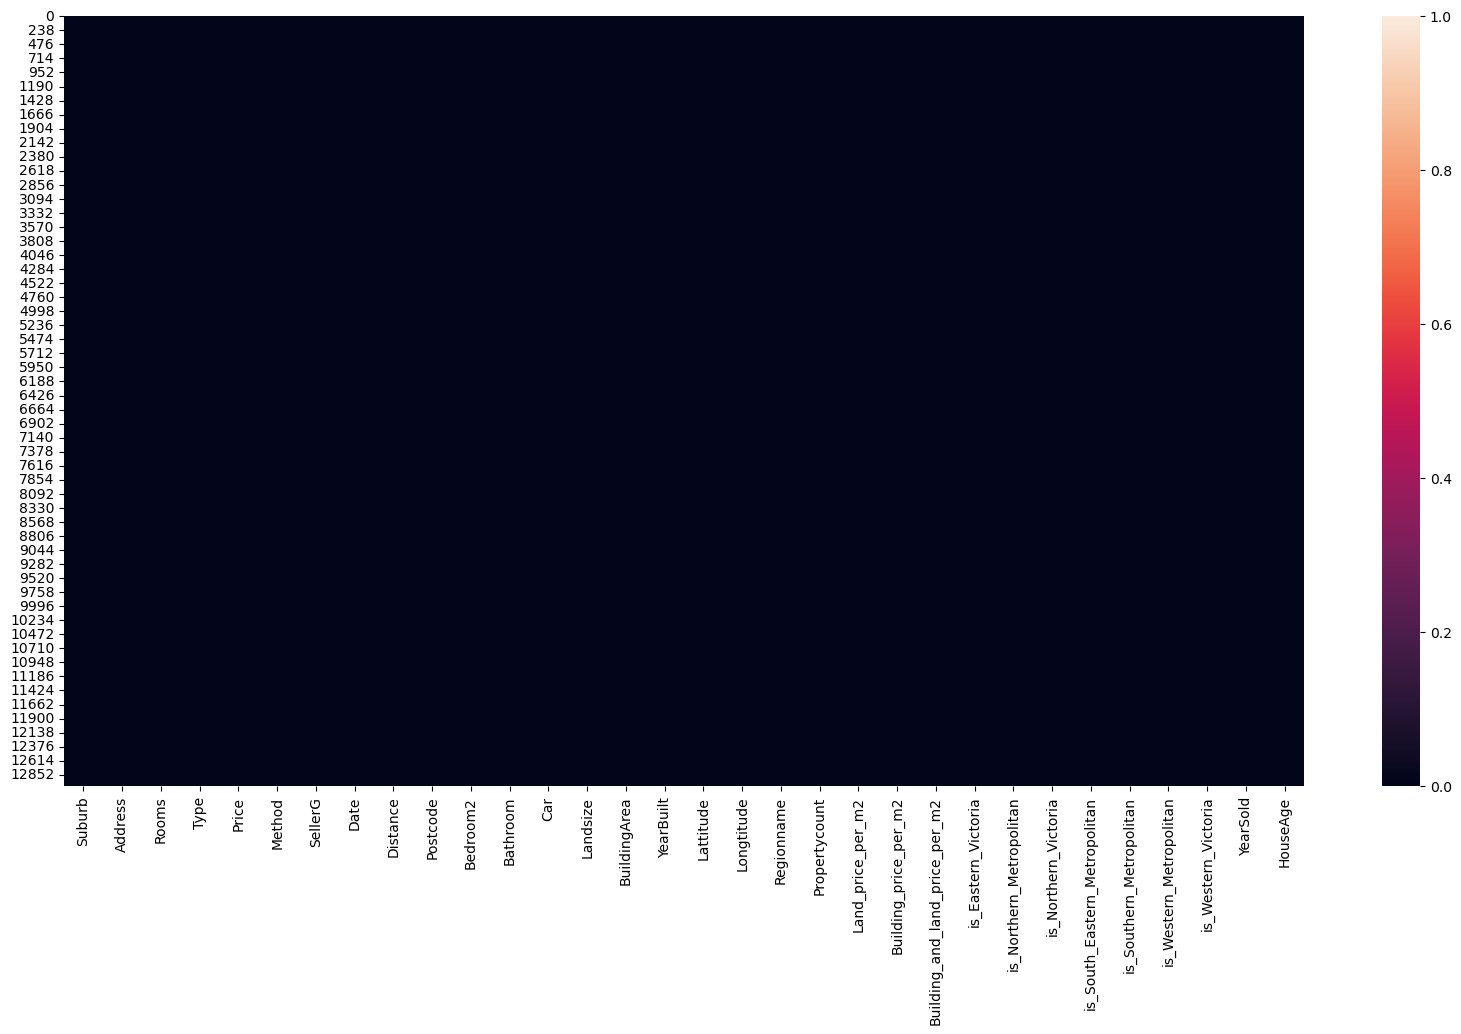

In [54]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.isna(), cbar=True)

In [55]:
#Missing values
missing_per_column = data.isnull().sum()
missing_per_column

Suburb                             0
Address                            0
Rooms                              0
Type                               0
Price                              0
Method                             0
SellerG                            0
Date                               0
Distance                           0
Postcode                           0
Bedroom2                           0
Bathroom                           0
Car                                0
Landsize                           0
BuildingArea                       0
YearBuilt                          0
Lattitude                          0
Longtitude                         0
Regionname                         0
Propertycount                      0
Land_price_per_m2                  0
Building_price_per_m2             17
Building_and_land_price_per_m2    17
is_Eastern_Victoria                0
is_Northern_Metropolitan           0
is_Northern_Victoria               0
is_South_Eastern_Metropolitan      0
i

In [73]:
#Reason behind the 17 missing values
zero_building = (data['BuildingArea']==0).sum()
zero_building

17

## Pre-Predictive Model

#### First we visualize the target variable: Price

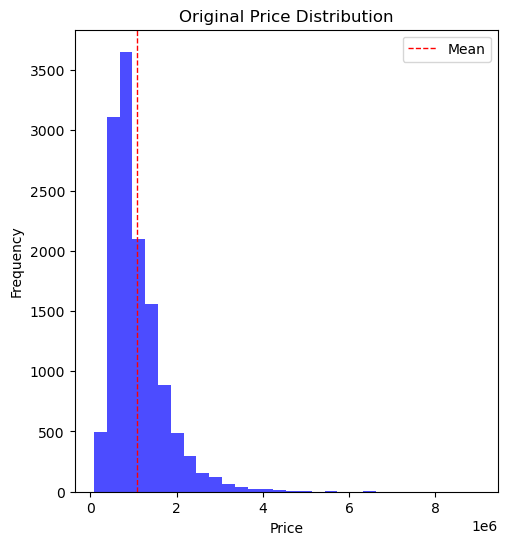

In [74]:
price= data['Price']
plt.figure(figsize=(12,6)) #set the figure size

#Original Price distribution
plt.subplot(1,2,1)
plt.hist(price,bins=30,alpha=0.7,color='blue')
plt.title('Original Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.axvline(price.mean(),color='red',linestyle='dashed',linewidth=1,label='Mean')
plt.legend()

#### Next, we log transform the target variable to handle outliers

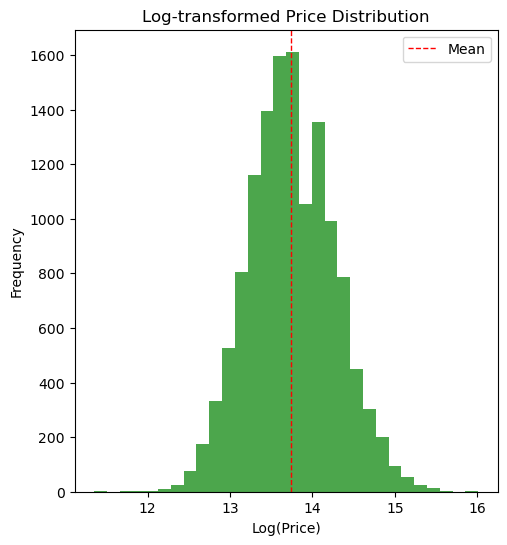

In [75]:
#Apply log transformation using numpy
log_price = np.log(price)

#Log transformed Price distribution
plt.figure(figsize=(12,6)) #set the figure size
plt.subplot(1,2,1)
plt.hist(log_price,bins=30,alpha=0.7,color='green')
plt.title('Log-transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.axvline(log_price.mean(),color='red',linestyle='dashed',linewidth=1,label='Mean')
plt.legend()

#### Check for outliers after log transformation

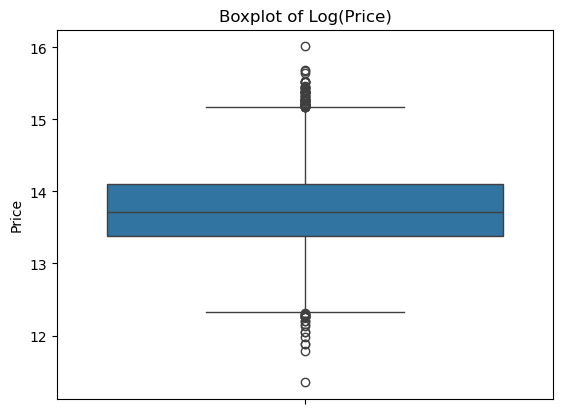

In [76]:
sns.boxplot(y=log_price)
plt.title("Boxplot of Log(Price)")
plt.show()

We might need to take care of those outliers, but I will ignore them for now.

### Best practices before applying predictive model

#### 1. Checking for Multicollinearity

In [83]:
predictors = data[['Rooms','Bathroom','Distance','Landsize']]
correlation_matrix = predictors.corr()
print(correlation_matrix)

             Rooms  Bathroom  Distance  Landsize
Rooms     1.000000  0.590661  0.283836  0.508916
Bathroom  0.590661  1.000000  0.122729  0.233081
Distance  0.283836  0.122729  1.000000  0.398563
Landsize  0.508916  0.233081  0.398563  1.000000


It makes sense that Rooms and Bathrooms have a moderately high correlation. Same with Rooms and Landsize, as a house with more rooms will likely have a larger land size. However, we can consider that correlation lower than 0.7 is nothing to worry about for the moment.

In [119]:
#Another check for multicollinearity: VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
print("VIF values:", vif)

VIF values: [1.0000000000000056, 1.9759596606172707, 1.5364385727692782, 1.19720545282335, 1.4902737628911233]


VIF values > 5 inidicate potential multicollinearity. We are good.

#### 2. Splitting the dataset into training and testing sets

In [81]:
from sklearn.model_selection import train_test_split

#Features and target variable
X = data[['Rooms','Bathroom','Distance','Landsize']].values
y = log_price

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

#### 3. Standardizing predictors

In [82]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 4. Adding the intercept column to X

In [98]:
X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("Shape of X_train (with intercept):", X_train_scaled.shape)
print("Shape of X_test (with intercept):", X_test_scaled.shape)

Shape of X_train (with intercept): (10438, 5)
Shape of X_test (with intercept): (2610, 5)


## Predictive Model

### First we define the model

In [99]:
#Likelihood Function
def log_likelihood(y,X,beta,sigma2):
    n=len(y)
    mu=np.dot(X,beta) #Predicted mean
    residuals=y-mu
    return -0.5*n*np.log(2*np.pi*sigma2)-np.sum(residuals**2)/(2*sigma2)

#Priors
from scipy.stats import norm, invgamma

#Normal Prior for coefficients
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta,loc=0,scale=10)) #Mean=0, Var=10^2

#Inverse-Gamma prior for the variance
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2,a=2,scale=1)

#Posterior
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2)+log_prior_beta(beta)+log_prior_sigma2(sigma2)

### Next, we implement the MCMC Algorithm using Metropolis-Hastings to draw samples from the posterior distribution

In [100]:
def metropolis_hastings(y,X, iterations=1000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    #Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    for sample in range(iterations):
        #Propose a new beta
        beta_proposal = beta + np.random.normal(0,0.1,size=n_params)

        #Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0,0.1)
        sigma2_proposal = abs(sigma2_proposal) #variance > 0

        #Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y,X, beta_proposal,sigma2_proposal)

        #Accept/reject step
        accept_ratio = np.exp(proposed_posterior-current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        #Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    return np.array(beta_samples), np.array(sigma2_samples)

### Finally, we run the model on the training data

In [101]:
#Run MCMC
beta_samples, sigma2_samples = metropolis_hastings(y_train,X_train_scaled,iterations=5000)

#Compute posterior means
beta_mean = np.mean(beta_samples, axis=0)
sigma2_mean = np.mean(sigma2_samples)

print("Posterior Mean of coefficients:",beta_mean)
print("Posterior Mean of Variance:",sigma2_mean)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_40256/3715273636.py:23: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior-current_posterior)


Posterior Mean of coefficients: [12.97041461  0.33391246  0.0903033  -0.11817655  0.02141409]
Posterior Mean of Variance: 1.0908792539951553


## Evaluating the Model

In [102]:
#Checking for NaNs
print("Number of NaNs in y_test:", np.isnan(y_test).sum())
print("Number of NaNs in X_test:", np.isnan(X_test).sum())
print("Number of NaNs in y_train:", np.isnan(y_train).sum())
print("Number of NaNs in X_train:", np.isnan(X_train).sum())

Number of NaNs in y_test: 0
Number of NaNs in X_test: 0
Number of NaNs in y_train: 0
Number of NaNs in X_train: 0


In [103]:
#Checking dimensions
print("X_test_scaled shape:", X_test_scaled.shape)
print("beta_mean shape:", beta_mean.shape)
print("Shape of X_train:", X_train_scaled.shape)

X_test_scaled shape: (2610, 5)
beta_mean shape: (5,)
Shape of X_train: (10438, 5)


In [106]:
print("Column mapping in beta_samples:")
print("0: Intercept")
print("1: Rooms")
print("2: Bathroom")
print("3: Distance")
print("4: Landsize")

Column mapping in beta_samples:
0: Intercept
1: Rooms
2: Bathroom
3: Distance
4: Landsize


### Making predictions and evaluating performance

In [104]:
#Predicting price using the mean of posterior samples
y_pred_log = np.dot(X_test_scaled,beta_mean)
y_pred_price = np.exp(y_pred_log)

#Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(np.exp(y_test), y_pred_price)
mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 599707.5281706107
Mean Squared Error: 620619013706.4159


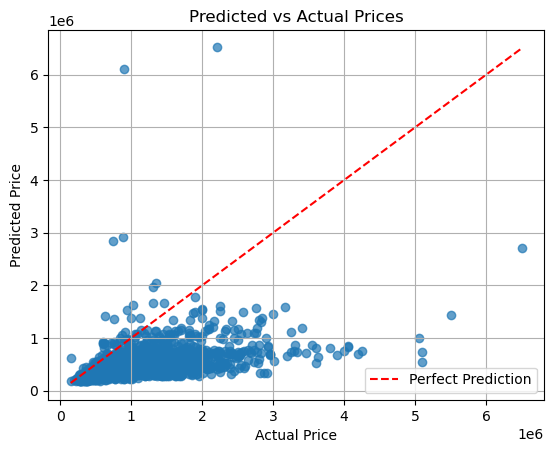

In [116]:
#Scatter plot of Predicted vs. Actual Values
plt.scatter(np.exp(y_test),y_pred_price,alpha=0.7)
plt.plot([min(np.exp(y_test)),max(np.exp(y_test))],[min(np.exp(y_test)),max(np.exp(y_test))],color='red',linestyle='--',label='Perfect Prediction')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid()
plt.show()

### Analyzing posterior distributions

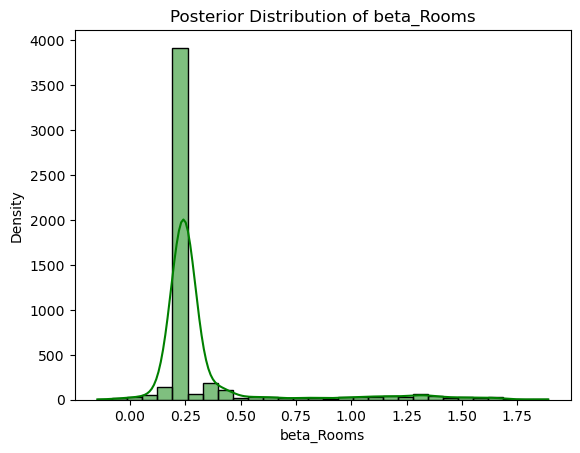

In [112]:
#Histograms of Posterior distributions
#1st: beta_rooms
beta_samples_df = pd.DataFrame(beta_samples, columns=['Intercept','Rooms','Bathroom','Distance','Landsize'])
sns.histplot(beta_samples_df['Rooms'],kde=True,bins=30,color='green')
plt.title("Posterior Distribution of beta_Rooms")
plt.xlabel("beta_Rooms")
plt.ylabel("Density")
plt.show()

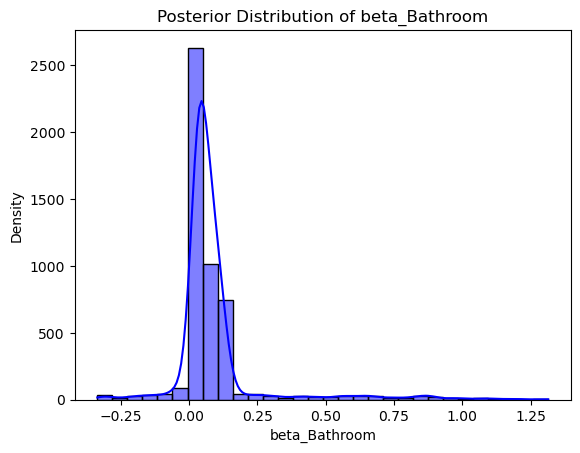

In [113]:
#2nd: beta_bathrooms
sns.histplot(beta_samples_df['Bathroom'],kde=True,bins=30,color='blue')
plt.title("Posterior Distribution of beta_Bathroom")
plt.xlabel("beta_Bathroom")
plt.ylabel("Density")
plt.show()

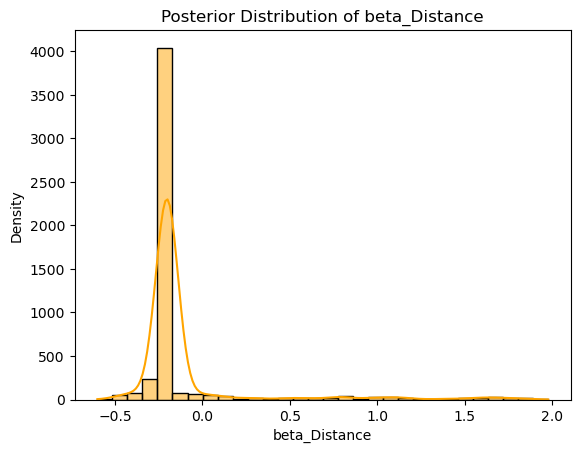

In [114]:
#3rd: beta_Distance
sns.histplot(beta_samples_df['Distance'],kde=True,bins=30,color='orange')
plt.title("Posterior Distribution of beta_Distance")
plt.xlabel("beta_Distance")
plt.ylabel("Density")
plt.show()

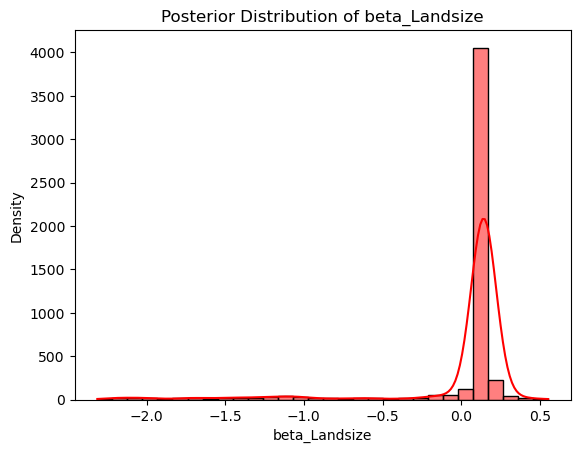

In [115]:
#4th: beta_LandSize
sns.histplot(beta_samples_df['Landsize'],kde=True,bins=30,color='red')
plt.title("Posterior Distribution of beta_Landsize")
plt.xlabel("beta_Landsize")
plt.ylabel("Density")
plt.show()

I notice that, although the distributions seem to be centered around one peak, one of the tails is always too long (wide). This might be a problem in the prediction model.

## Improving the model

#### Hypothesis (1): there are outliers in the target variable log(Price) which are decreasing the performance of the model.

In [117]:
#Identifying outliers
Q1 = np.percentile(y,25)
Q3 = np.percentile(y,75)
IQR = Q3 - Q1

#Defining bounds
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

#Counting outliers
outliers = y[(y<lower_bound)|(y>upper_bound)]
print("Number of outliers in log(Price):", len(outliers))

Number of outliers in log(Price): 81


Ok, hypothesis rejected... there are not so many outliers.

#### Hypothesis (2) Model is Overfitting or Underfitting

We calculate MAE/MSE for the training data and we compare it to the MSE of the test data. If the model is Overfitting, then training error < test error, if the model is Underfitting then both errors are high.

IMO it's more likely to be underfitting (too simple model), but let's see.

In [121]:
#First, we need to predict the price based on the training data
y_train_pred_log = np.dot(X_train_scaled,beta_mean)

#Then we transform the log price back to its original price scale
y_train_pred_price = np.exp(y_train_pred_log)

In [123]:
#MSE Comparison
train_mse = mean_squared_error(np.exp(y_train),y_train_pred_price)
test_mse = mean_squared_error(np.exp(y_test),y_pred_price)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Train MSE: 663410545221.968
Test MSE: 620619013706.4159


In [124]:
#MAE Comparison
train_mae = mean_absolute_error(np.exp(y_train),y_train_pred_price)
test_mae = mean_absolute_error(np.exp(y_test),y_pred_price)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Train MAE: 618965.8292793479
Test MAE: 599707.5281706107


Both errors are pretty high. Model is underfitting.